<a href="https://colab.research.google.com/github/JinXianWen95/PyTorch-bootcamp/blob/main/09_pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment

Machine learning deployment is the act of making the machine learning model(s) available to someone/something else

## 0. Setup

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
import torch
import torchvision

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4410, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 4410 (delta 5), reused 2 (delta 2), pack-reused 4400 (from 2)
Receiving objects: 100% (4410/4410), 764.18 MiB | 25.90 MiB/s, done.
Resolving deltas: 100% (2662/2662), done.
Updating files: 100% (248/248), done.


In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


## 1. FooldVison Mini model deployment experiment outline

### 3 questions
1. What is the most ideal machine learning model deployment scenario?
2. Where is the going to go?
3. How is the model going to function

**FoodVision Mini ideal use case:** A model that performs well and fast.

* Performs well: 95%+ accuracy
* Fast: as close to real-time (or faster) as possbile (30FPS+ or 30ms latency)

We're going to build two model experiments:
1. EffNetB2 feature extractor (like in 07. PyTorch Experiment Tracking)
2. ViTfeature extractor (like in 08. PyTroch Paper Replicating)

## 2. Creating an EffNetB2 feature extractor

In [ ]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will freeze all layers to begin with)
for param in effnetb2.parameters():
    param.requires_grad = False

print(effnetb2.classifier)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 102MB/s] 


Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)


In [4]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [ ]:
from torchinfo import summary

effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)
# Print EffNetB2 model summary
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 177MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 2.1 Creating Dataloaders for EffNetB2 and Training

In [ ]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

print(len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names)

15 5 ['pizza', 'steak', 'sushi']


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


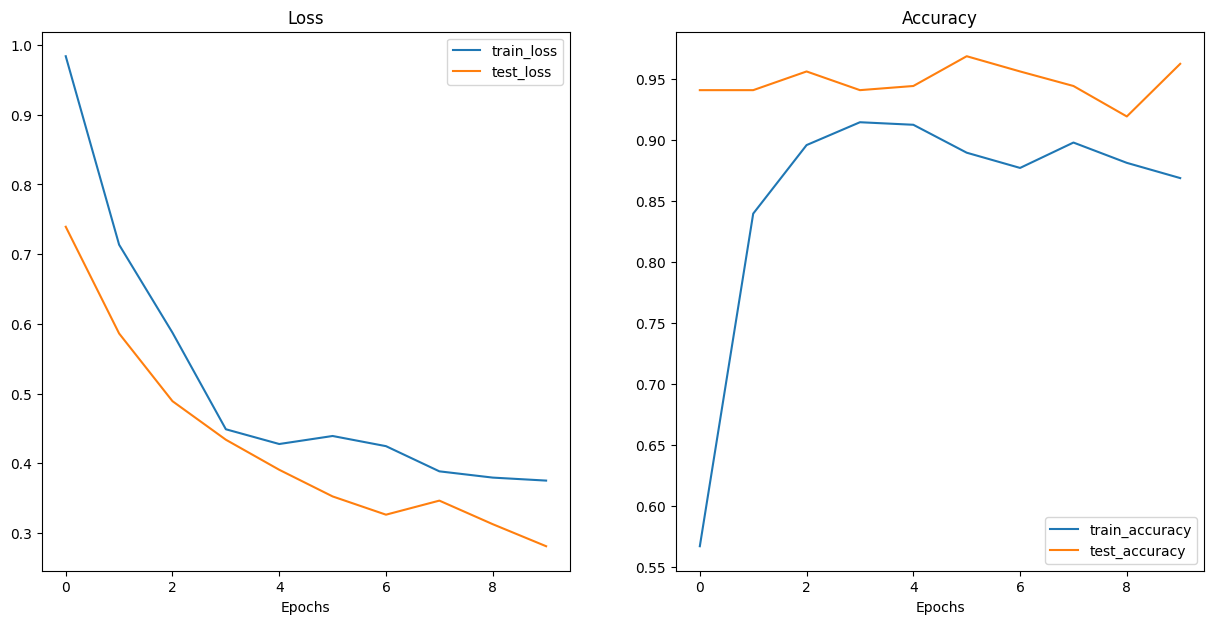

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 2.2 Saving the EffNetB2 model to File

In [ ]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
Pretrained EffNetB2 feature extractor model size: 29 MB


### 2.3 Collect Stats for EffNetB2 model

In [ ]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.28108683228492737,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## 3. Creating a ViT feature extractor

In [ ]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [ ]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 175MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 3.1 Creating Dataloader for ViT and training

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


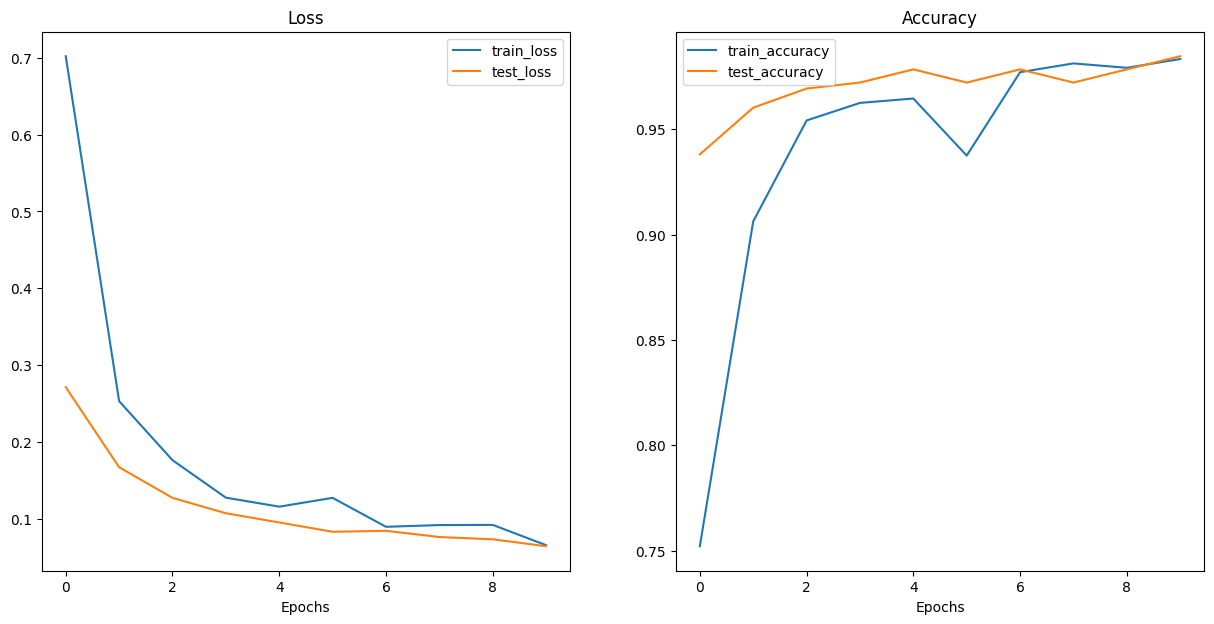

In [ ]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

### 3.2 Saving ViT to file

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())

vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth
Pretrained ViT feature extractor model size: 327 MB


{'test_loss': 0.06443452327512204,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## 4. Making predictions with the trained models and timing

To test the speed of predictions:
1. Loop through test images
2. Time how long each model takes to make a prediction on the image

In [ ]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(
    paths: List[pathlib.Path],
    model: torch.nn.Module,
    transform: torchvision.transforms,
    class_names: List[str],
    device
) -> List[Dict]:
  # 2. Create an empty list to store prediction dictionaries
  pred_list = []

  # 3. Loop through target paths
  for path in tqdm(paths):

    # 4. Create empty dictionary to store prediction information for each sample
    pred_dict = {}

    # 5. Get the sample path and ground truth class name
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # 6. Start the prediction timer
    start_time = timer()

    # 7. Open image path
    img = Image.open(path)

    # 8. Transform the image, add batch dimension and put image on target device
    transformed_image = transform(img).unsqueeze(0).to(device)

    # 9. Prepare model for inference by sending it to target device and turning on eval() mode
    model.to(device)
    model.eval()

    # 10. Get prediction probability, predicition label and prediction class
    with torch.inference_mode():
      pred_logit = model(transformed_image) # perform inference on target sample
      pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
      pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
      pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

      # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      # 12. End the timer and calculate time per pred
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time-start_time, 4)

      # 13. Does the pred match the true label?
      pred_dict["correct"] = class_name == pred_class

      # 14. Add the dictionary to the list of preds
      pred_list.append(pred_dict)

  # 15. Return list of prediction dictionaries
  return pred_list

### 4.1 Making and timing predictions with EffNetB2

Two things to note:
1. Device - we're going to hardcode the predictions to happen on CPU because we won't be always be sure of having a GPU when the model is deployed
2. Transfroms - we want to make sure each each of the models are predicting on images that have been prepare with the appropriate transforms.

In [ ]:
from pathlib import Path

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

print(effnetb2_test_pred_dicts[:2])

  0%|          | 0/150 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/593071.jpg'), 'class_name': 'sushi', 'pred_prob': 0.8276, 'pred_class': 'sushi', 'time_for_pred': 0.2604, 'correct': True}, {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2903621.jpg'), 'class_name': 'sushi', 'pred_prob': 0.7403, 'pred_class': 'sushi', 'time_for_pred': 0.1024, 'correct': True}]


In [ ]:
import pandas as pd

# Turn the test_pred_dicts into a DataFrame
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.8276,sushi,0.2604,True
1,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.7403,sushi,0.1024,True
2,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9492,sushi,0.0974,True
3,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.9095,sushi,0.0948,True
4,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.8756,sushi,0.1029,True
...,...,...,...,...,...,...
145,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.5919,steak,0.0784,True
146,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.7753,steak,0.0853,True
147,data/pizza_steak_sushi_20_percent/test/steak/7...,steak,0.9469,steak,0.0903,True
148,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.7198,steak,0.0878,True


In [ ]:
# Check number of correct predictions
print(effnetb2_test_pred_df.correct.value_counts())

# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

                                          image_path class_name  pred_prob  \
0  data/pizza_steak_sushi_20_percent/test/sushi/5...      sushi     0.8276   
1  data/pizza_steak_sushi_20_percent/test/sushi/2...      sushi     0.7403   
2  data/pizza_steak_sushi_20_percent/test/sushi/1...      sushi     0.9492   
3  data/pizza_steak_sushi_20_percent/test/sushi/5...      sushi     0.9095   
4  data/pizza_steak_sushi_20_percent/test/sushi/1...      sushi     0.8756   

  pred_class  time_for_pred  correct  
0      sushi         0.2604     True  
1      sushi         0.1024     True  
2      sushi         0.0974     True  
3      sushi         0.0948     True  
4      sushi         0.1029     True  
correct
True     144
False      6
Name: count, dtype: int64
EffNetB2 average time per prediction: 0.0908 seconds


{'test_loss': 0.28108683228492737,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': np.float64(0.0908)}

**Note:** Prediction times will vary depending on the hardware. Generally the faster the compute, the faster is the predcition.

### 4.2 Making and timing predictions with ViT

In [ ]:
from pathlib import Path

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu") # make predictions on CPU

print(vit_test_pred_dicts[:2])

  0%|          | 0/150 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/593071.jpg'), 'class_name': 'sushi', 'pred_prob': 0.9967, 'pred_class': 'sushi', 'time_for_pred': 0.5623, 'correct': True}, {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2903621.jpg'), 'class_name': 'sushi', 'pred_prob': 0.9072, 'pred_class': 'sushi', 'time_for_pred': 0.5361, 'correct': True}]


In [ ]:
import pandas as pd

vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.9967,sushi,0.5623,True
1,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9072,sushi,0.5361,True
2,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9876,sushi,0.6020,True
3,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.9891,sushi,0.5079,True
4,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9632,sushi,0.5401,True
...,...,...,...,...,...,...
145,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.7757,steak,0.3571,True
146,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.9387,steak,0.3573,True
147,data/pizza_steak_sushi_20_percent/test/steak/7...,steak,0.9916,steak,0.3760,True
148,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9986,steak,0.3632,True


In [ ]:
# Check number of correct predictions
print(vit_test_pred_df.correct.value_counts())

# Find the average time per prediction
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
print(vit_stats)

correct
True     148
False      2
Name: count, dtype: int64
ViT average time per prediction: 0.4138 seconds
{'test_loss': 0.06443452327512204, 'test_acc': 0.984659090909091, 'number_of_parameters': 85800963, 'model_size (MB)': 327, 'time_per_pred_cpu': np.float64(0.4138)}


Which model is better?
* `test_loss` (lower is better) - ViT
* `test_acc` (higher is better) - ViT
* `number_of_parameters` (generally lower is better, not always) - EffNetB2, if a model has more parameters, it generraly takes longer to compute
* `model_size (MB)` - EffNetB2 (for our case of deploying a mobile device, lower is better)
* `time_per_pred_cpu` (lower is better) - EffNetB2

Both models fail to achieve 30+ FPS goal...however we could always try and use EffNetB2 and see hot it goes.

## 5. Compare model results, prediction times and size

In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)
print(df)

# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T # Transpose

   test_loss  test_acc  number_of_parameters  model_size (MB)  \
0   0.281087     96.25               7705221               29   
1   0.064435     98.47              85800963              327   

   time_per_pred_cpu     model  
0             0.0908  EffNetB2  
1             0.4138       ViT  


,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.229234,1.023065,11.135432,11.275862,4.557269


### 5.1 Visualize the speed vs. performance tradeoff

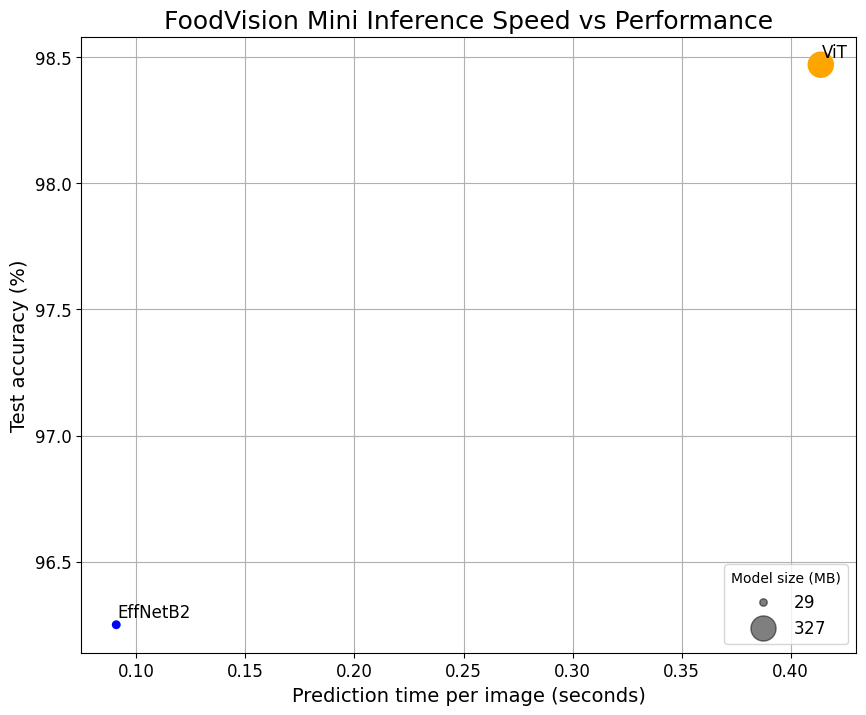

In [ ]:
# 1. Create a plot from model comparison DataFrame
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)") # size of the dot

# 2. Add titles and labels
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03), # position
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5) # alpha is opacity
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

## 6. Bringing FoodVision Mini to life by creating a Gradio demo

We've chosen to deploy EffNetB2 as it fulfills our criteria the best.

What is Gradio? https://www.gradio.app/

> Create web interfaces for your ML models in minutes. Deploy anywhere, share with anyone.


In [ ]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

Gradio version: 5.50.0


### 6.1 Gradio overview

Gradio helps to create machine learning demos.

Deployment is as important as training.

The overall premise of Gradio is to map the inputs -> function/model -> outputs.

In [ ]:
# Put the model on the cpu
effnetb2 = effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

### 6.2 Creating a function to map the inputs and outputs

In [ ]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]: # (food class label, prediction time)
  # start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  transformed_image = effnetb2_transforms(img).unsqueeze(0)

  # Put the model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    pred_logit = effnetb2(transformed_image)
    pred_probs = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities

    # Create a prediction label and prediction prob dict
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # return pred dict and time
  return pred_labels_and_probs, pred_time

In [ ]:
import random

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/pizza/420409.jpg

Prediction label and probability dictionary: 
{'pizza': 0.7845796346664429, 'steak': 0.041292455047369, 'sushi': 0.17412781715393066}
Prediction time: 0.0822 seconds


### 6.3 Creating a list of example images

In [ ]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)] # gradio requires list of list
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/2398925.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/697562.jpg']]

### 6.4 Building a Gradio Interface

Let's use `gr.Interface()` to go from:

```
input: image -> transform -> predict with effnetb2 -> output: pred, prob, time
```

In [ ]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://241ae470d2d6a4398a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 7. Turning the FoodVision Mini Gradio Demo into a deployable app



### 7.1 Deployed Gradip app structure

Let's start to put all of the app files into a single directory
```
Colab -> folder with all Gradio files -> upload app files to Hugging Face Spaces -> deploy
```

By the end the file structure will look like this:
```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```


### 7.2 Create the app structure with dir and files

In [ ]:
import shutil
from pathlib import Path

# Create FoodVison mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might exist and create a new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)
else:
    foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

# Check what's in the folder
!ls demos/foodvision_mini/

In [ ]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


[['examples/592799.jpg'], ['examples/3622237.jpg'], ['examples/2582289.jpg']]

In [ ]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] No model found at models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth, perhaps its already been moved?
[INFO] Model exists at demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth: False


In [ ]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_mini/model.py


In [ ]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


### 7.3 Create `requirements.txt`
This will be a text file containing all of the required dependencies for our demo.

When we deploy our demo app to Hugging Face Spaces, it will search through this file and install the dependencies we define so our app can run.

In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.10.0
torchvision==0.25.0
gradio==6.5.1

Writing demos/foodvision_mini/requirements.txt


## 8. Deploying the FoodVision Mini app to HuggingFace Spaces

### 8.1 Downloading the FoodVision Mini app files

We want to download the demo app so we can upload it to Hugging Face Spaces

In [ ]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*" # -x means exclude thse classes

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_mini.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

  adding: app.py (deflated 57%)
  adding: examples/ (stored 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: model.py (deflated 55%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 8.3 Uploading the FoodVision to Hugging Face

https://www.learnpytorch.io/09_pytorch_model_deployment/


In [59]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://xwjin-gradio-test.hf.space", width=900, height=750)

## 9. Creating FoodVision Big

FoodVision Mini works weel with 3 classes.

Let's step things up a notch and make FoodVision Big using all of the Food101 classes.

### 9.1 Creating model for FoodVision and transforms

In [52]:
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)
summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Since we're working with a larger dataset, we may want to introduce some data augmentation techniques:
* This is because with larger datasets and larger models, overfitting becomes more of a problem.
* Because we're working with a large number of classes, let's use TrivialAugment as the data augmentation technique

In [53]:
from torchvision.transforms import v2

food_101_transforms = v2.Compose([
    v2.TrivialAugmentWide(),
    effnetb2_transforms
])

### 9.2 Getting data for FoodVision Big

I will use Kaggle API to avoid downloading data every time connecting to colab

In [22]:
import os
import shutil
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive, userdata

# 1. MOUNT GOOGLE DRIVE
drive.mount('/content/drive')

# 2. DEFINE PATHS
# Persistent storage on your Drive
drive_base_path = "/content/drive/MyDrive/colab_copilot_data/data"
drive_zip_path = os.path.join(drive_base_path, "food-101.tar.gz")

# High-speed local storage on Colab's NVMe
local_data_dir = "/content/data"
local_zip_path = "/content/food-101.tar.gz"

# 3. PERMANENT STORAGE CHECK (One-time download to Drive)
if not os.path.exists(drive_zip_path):
    print("🚀 Initial setup: Downloading Food-101 to your Google Drive...")
    os.makedirs(drive_base_path, exist_ok=True)
    # This downloads to Drive via Google's backbone (no local data used)
    datasets.Food101(root=drive_base_path, split='train', download=True)
else:
    print("✅ Dataset found in Google Drive.")

# 4. FAST LOCAL COPY (Internal Google transfer - 0% internet data)
if not os.path.exists(local_data_dir):
    print("📦 Moving archive to local high-speed disk...")
    shutil.copy(drive_zip_path, local_zip_path)

    print("🏗️ Extracting locally...")
    os.makedirs(local_data_dir, exist_ok=True)
    !tar -xzf {local_zip_path} -C {local_data_dir}

    # Clean up the local zip to free up space
    os.remove(local_zip_path)
    print("🚀 Data is now local and ready for fast training!")

# 5. DEFINE TRANSFORMS
food101_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 6. CREATE DATASETS (Point to LOCAL path)
train_data = datasets.Food101(root=local_data_dir,
                              split="train",
                              transform=food101_transforms,
                              download=False)

test_data = datasets.Food101(root=local_data_dir,
                             split="test",
                             transform=food101_transforms,
                             download=False)

# 7. CREATE DATALOADERS
# num_workers=2 and pin_memory=True maximize GPU throughput
train_loader = DataLoader(train_data,
                          batch_size=32,
                          shuffle=True,
                          num_workers=2,
                          pin_memory=True)

test_loader = DataLoader(test_data,
                         batch_size=32,
                         shuffle=False,
                         num_workers=2,
                         pin_memory=True)

print(f"\nFinal Check:")
print(f"Total training samples: {len(train_data)}")
print(f"Total testing samples: {len(test_data)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset found in Google Drive.

Final Check:
Total training samples: 75750
Total testing samples: 25250


In [24]:
train_dir = Path(local_data_dir) / "train"
test_dir = Path(local_data_dir) / "test"

### 9.3 Creating a subset of the Food101 dataset for faster experimening

We want our first experiments to run as quick as possibile.

We know FoodVision Mini works pretty well but this is the first time we've upgraded to 101 classes.

To do so, let's make a subset 20% of the food101 dataset.

In [27]:
from torch.utils.data import random_split

def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
  # Create split lengths based on the original dataset length
  length_1 = int(len(dataset) * split_size)
  length_2 = len(dataset) - length_1

  print(f'[INFO] Splitting dataset of legth {len(dataset)} into splits of size: {length_1} and {length_2}')

  # Create splits
  split_1, split_2 = torch.utils.data.random_split(dataset,
                                                   lengths=[length_1, length_2],
                                                   generator=torch.manual_seed(seed))

  return split_1, split_2

In [30]:
# Create training 20% split Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                              split_size=0.2)

test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                              split_size=0.2)

[INFO] Splitting dataset of legth 75750 into splits of size: 15150 and 60600
[INFO] Splitting dataset of legth 25250 into splits of size: 5050 and 20200


In [31]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Create Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

print(len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent))

474 158


### 9.4  Training FoodVision

Things for training:
* 5 epochs
* Optimizer: torch.optim.Adam(lr=1e-3)
* Loss function: torch.nn.CrossEntropyLoss(label_smoothing=0.1)

Why use label smoothing?

Label smoothing helps to prevent overfitting.

Without label smoothing and 5 classes:
```
[0.00, 0.00, 0.99, 0.01, 0.00]
```

With label smoothing and 5 classes:
```
[0.01, 0.01, 0.96, 0.01, 0.01]
```

In [39]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                train_dataloader=train_dataloader_food101_20_percent,
                                test_dataloader=test_dataloader_food101_20_percent,
                                epochs=5,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6868 | train_acc: 0.2591 | test_loss: 3.0166 | test_acc: 0.4224
Epoch: 2 | train_loss: 2.8644 | train_acc: 0.4364 | test_loss: 2.7057 | test_acc: 0.4726
Epoch: 3 | train_loss: 2.6260 | train_acc: 0.4893 | test_loss: 2.6264 | test_acc: 0.4873
Epoch: 4 | train_loss: 2.5077 | train_acc: 0.5159 | test_loss: 2.5929 | test_acc: 0.4796
Epoch: 5 | train_loss: 2.4421 | train_acc: 0.5366 | test_loss: 2.5796 | test_acc: 0.4817


### 9.5 Inspecting loss curves

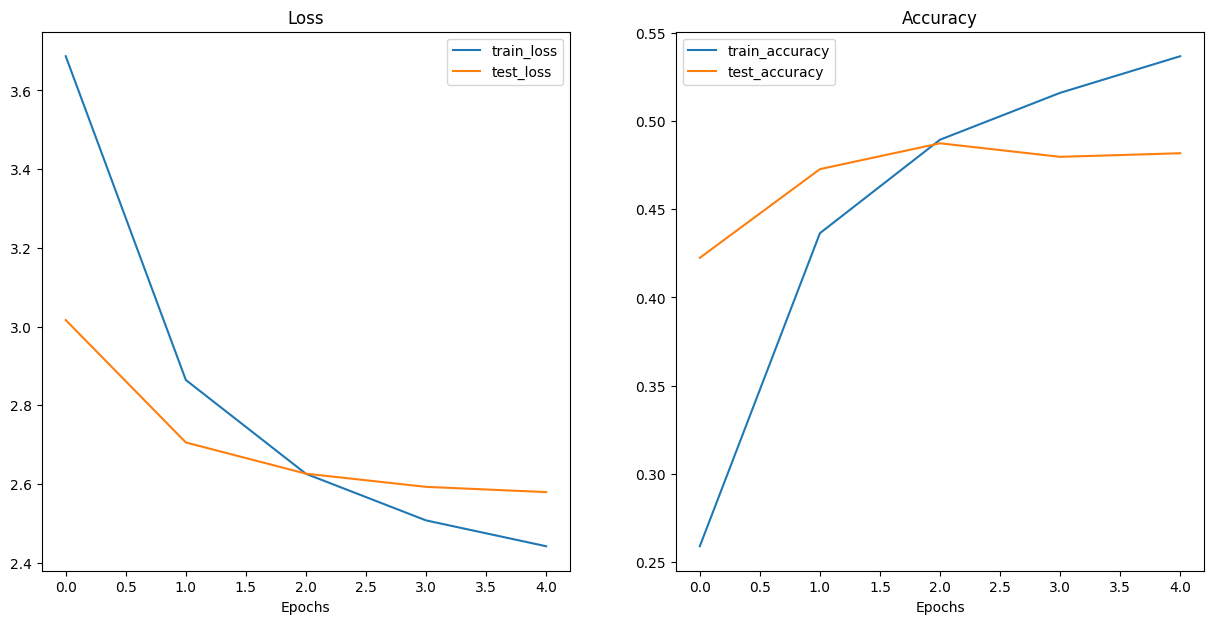

In [40]:
from helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_results)

### 9.6 Save and load FoodVision big model

In [41]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


## 10. Turning FoodVision Big into a deployable app

```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```

In [43]:
import shutil
from pathlib import Path

# Create FoodVison mini demo path
foodvision_demo_path = Path("demos/foodvision/")

# Remove files that might exist and create a new directory
if foodvision_demo_path.exists():
    shutil.rmtree(foodvision_demo_path)
    foodvision_demo_path.mkdir(parents=True, exist_ok=True)
else:
    foodvision_demo_path.mkdir(parents=True, exist_ok=True)

# 1. Create an examples directory
foodvision_examples_path = foodvision_demo_path / "examples"
foodvision_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_examples = [Path('/content/data/food-101/images/apple_pie/1005649.jpg'),
                            Path('/content/data/food-101/images/bruschetta/1031947.jpg'),
                            Path('/content/data/food-101/images/chicken_quesadilla/1004279.jpg')]

for example in foodvision_examples:
    destination = foodvision_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision

[INFO] Copying /content/data/food-101/images/apple_pie/1005649.jpg to demos/foodvision/examples/1005649.jpg
[INFO] Copying /content/data/food-101/images/bruschetta/1031947.jpg to demos/foodvision/examples/1031947.jpg
[INFO] Copying /content/data/food-101/images/chicken_quesadilla/1004279.jpg to demos/foodvision/examples/1004279.jpg


### 10.1 Saving Food101 class names to file `class_names.txt`

Let's save all of the Food101 class names to a .txt file so we can import them and use in the app


In [46]:
# Create path to Food101 class names
foodvision_class_names_path = foodvision_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_class_names_path}")
    f.write("\n".join(train_data_food101_20_percent.dataset.classes)) # leave a new line between each class

# Open Food101 class names file and read each line into a list
with open(foodvision_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in  f.readlines()]

# View the first 5 class names loaded back in
food101_class_names_loaded[:5]

[INFO] Saving Food101 class names to demos/foodvision/class_names.txt


['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### 10.2 Model and App scripts

In [47]:
%%writefile demos/foodvision/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms


Writing demos/foodvision/model.py


In [48]:
%%writefile demos/foodvision/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]

### 2. Model and transforms preparation ###

# Create model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=101, # could also use len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Writing demos/foodvision/app.py


In [49]:
%%writefile demos/foodvision/requirements.txt
torch==2.10.0
torchvision==0.25.0
gradio==6.5.1

Writing demos/foodvision/requirements.txt


### 10.3 Download the App

In [51]:
# Zip foodvision_big folder but exclude certain files
!cd demos/foodvision && zip -r ../foodvision.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")


  adding: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: app.py (deflated 54%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/1005649.jpg (deflated 0%)
  adding: examples/1031947.jpg (deflated 3%)
  adding: examples/1004279.jpg (deflated 0%)
  adding: model.py (deflated 56%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
# IPython is a library to help work with Python interactively
from IPython.display import IFrame

# Embed FoodVision Big Gradio demo as an iFrame
IFrame(src="https://xwjin-foodvision101.hf.space", width=900, height=750)

## 11. Train on full dataset

In [54]:
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)
summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

food_101_transforms = v2.Compose([
    v2.TrivialAugmentWide(),
    effnetb2_transforms
])

from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                train_dataloader=train_loader,
                                test_dataloader=test_loader,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.0616 | train_acc: 0.3822 | test_loss: 2.4557 | test_acc: 0.5301
Epoch: 2 | train_loss: 2.7157 | train_acc: 0.4601 | test_loss: 2.3847 | test_acc: 0.5464
Epoch: 3 | train_loss: 2.6787 | train_acc: 0.4698 | test_loss: 2.3577 | test_acc: 0.5559
Epoch: 4 | train_loss: 2.6578 | train_acc: 0.4749 | test_loss: 2.3770 | test_acc: 0.5481
Epoch: 5 | train_loss: 2.6603 | train_acc: 0.4756 | test_loss: 2.3426 | test_acc: 0.5586
Epoch: 6 | train_loss: 2.6498 | train_acc: 0.4792 | test_loss: 2.3371 | test_acc: 0.5617
Epoch: 7 | train_loss: 2.6484 | train_acc: 0.4805 | test_loss: 2.3650 | test_acc: 0.5553
Epoch: 8 | train_loss: 2.6439 | train_acc: 0.4819 | test_loss: 2.3584 | test_acc: 0.5548
Epoch: 9 | train_loss: 2.6478 | train_acc: 0.4807 | test_loss: 2.3393 | test_acc: 0.5620
Epoch: 10 | train_loss: 2.6430 | train_acc: 0.4804 | test_loss: 2.3548 | test_acc: 0.5558


In [55]:
# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101.pth"))

from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) #

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101.pth


In [57]:
%%writefile app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]

### 2. Model and transforms preparation ###

# Create model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=101, # could also use len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_food101.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Writing app.py
